In [335]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix


### 1- Load and wrangle the data

Fisrt we will explore the data set, drop the un wanted columns, rename some of them. Also as we know adopted user is defined as as user that is using their account 3 times in a 7 days window. We will create the target column to explore the corrolation of the independent features with our target.

In [336]:
# load the data
user_info_df = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
user_eng_df = pd.read_csv('takehome_user_engagement.csv',parse_dates = ['time_stamp'],index_col='time_stamp')

In [233]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [234]:
user_info_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [337]:
print(user_info_df['invited_by_user_id'].isnull().sum())

5583


In [338]:
# change invited to 1 and 0, instead of the userId
user_info_df['invited'] = user_info_df['invited_by_user_id'].notnull().astype('int')

In [339]:
# drop the unnecessary columns and rename the columns
user_info = user_info_df.drop(['creation_time','name','email','last_session_creation_time','org_id','invited_by_user_id'], axis=1)
user_info = user_info.rename(columns={'object_id':'user_id'})


In [238]:
user_info.head()

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,invited
0,1,GUEST_INVITE,1,0,1
1,2,ORG_INVITE,0,0,1
2,3,ORG_INVITE,0,0,1
3,4,GUEST_INVITE,0,0,1
4,5,GUEST_INVITE,0,0,1


There is still one column with categorigal type, we need to convert this to numberical.

In [239]:
# transfor categorical to numberic with get_dummy pandas function
user_info = pd.get_dummies(user_info, dtype=np.int64)
user_info.head()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,1,1,0,0,0,0
1,2,0,0,1,0,1,0,0,0
2,3,0,0,1,0,1,0,0,0
3,4,0,0,1,1,0,0,0,0
4,5,0,0,1,1,0,0,0,0


In [240]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   user_id                             12000 non-null  int64
 1   opted_in_to_mailing_list            12000 non-null  int64
 2   enabled_for_marketing_drip          12000 non-null  int64
 3   invited                             12000 non-null  int64
 4   creation_source_GUEST_INVITE        12000 non-null  int64
 5   creation_source_ORG_INVITE          12000 non-null  int64
 6   creation_source_PERSONAL_PROJECTS   12000 non-null  int64
 7   creation_source_SIGNUP              12000 non-null  int64
 8   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  int64
dtypes: int64(9)
memory usage: 843.9 KB


Our user_info data looks good. Lets define a new column which is 'adopted' to our data as below:


In [241]:
user_eng_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [242]:
user_eng_7days = user_eng_df.sort_index().groupby(['user_id']).resample('7d').sum()

In [243]:
user_eng_7days.sample(5)

,,user_id,visited
user_id,time_stamp,,
8259,2013-10-15,24777,3
2038,2013-12-10,4076,2
4680,2013-06-02,32760,7
4255,2012-10-24,4255,1
3671,2013-09-13,11013,3


As seen in the above dataframe, we resamples the data in a - 7 day - window and sum up. user_id column has no value for our aim. Lets get the ids of the users with visited more than 3 times in 7 days.


In [244]:
adopted_user_ids = user_eng_7days[user_eng_7days['visited'] >= 3][['visited']].reset_index()['user_id'].unique()
adopted_user_ids[:100]

array([  2,  10,  20,  42,  43,  53,  63,  69,  74,  80,  81,  82,  87,
       133, 135, 141, 146, 153, 160, 165, 168, 172, 174, 185, 188, 197,
       200, 202, 203, 209, 214, 230, 245, 247, 263, 265, 275, 280, 283,
       297, 298, 305, 310, 311, 322, 341, 347, 351, 363, 370, 383, 401,
       418, 430, 445, 450, 460, 462, 469, 471, 472, 479, 483, 492, 494,
       497, 509, 510, 512, 518, 522, 529, 535, 540, 547, 553, 564, 572,
       589, 591, 601, 603, 605, 618, 627, 628, 632, 634, 639, 669, 679,
       680, 724, 725, 728, 754, 772, 783, 786, 804])

Now we have the list of users that are adopted. We will add a column to our user_info table, that has a 1 values if the user id is in the adopted list, 0 if not.

In [245]:
user_info.set_index('user_id', inplace=True)
user_info['adopted'] = 0
for user_id in adopted_user_ids:
    user_info.at[user_id, 'adopted'] = 1

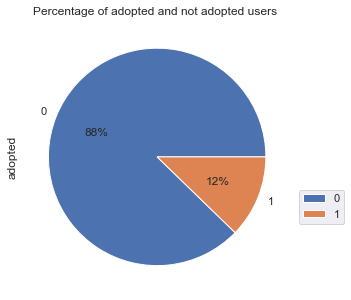

In [285]:
#plot the number of adopted and not adopted users
user_info_adopted = user_info.groupby(['adopted'])['adopted'].count()
fig, ax = plt.subplots(figsize=(15,5))
user_info_adopted.plot(kind ='pie',ax=ax ,autopct='%1.0f%%')
plt.title('Percentage of adopted and not adopted users ')
plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

### 2- EDA and corrolation calculation

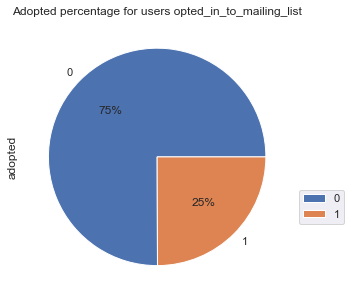

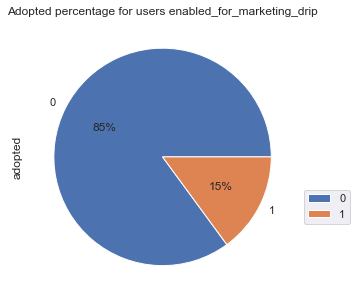

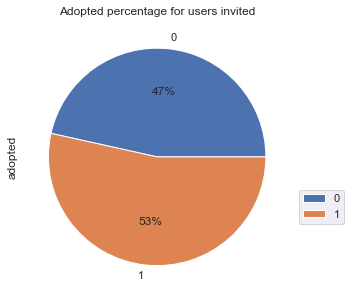

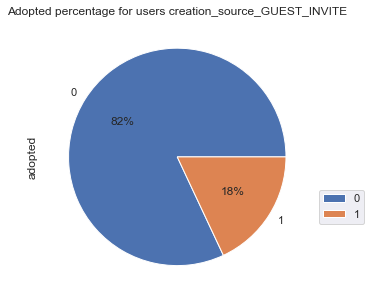

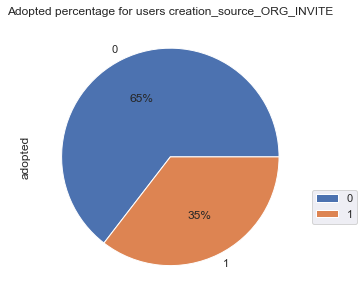

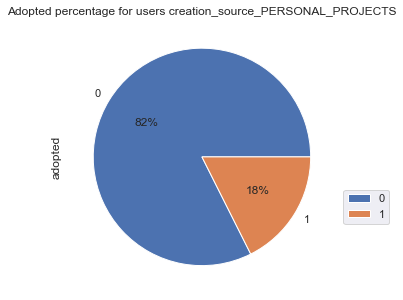

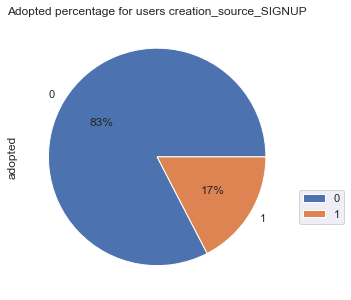

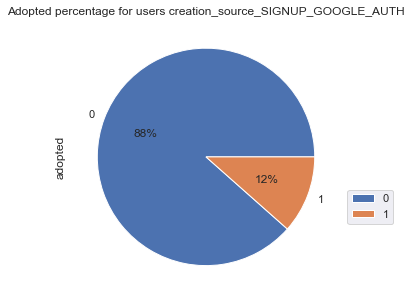

In [282]:
# #active-deactive users based on city
for column in user_info.columns:
    if column != 'adopted':
        user_info_grouped = user_info.groupby([column])['adopted'].count()
        fig, ax = plt.subplots(figsize=(15,5))
        user_info_grouped.plot(kind ='pie',ax=ax ,autopct='%1.0f%%')
        plt.title('Adopted percentage for users {}'.format(column))
        plt.legend(loc="upper left",bbox_to_anchor=(1,0.4))

The best approach to findout how the features are corrolated is using a heatmap graph

<AxesSubplot:>

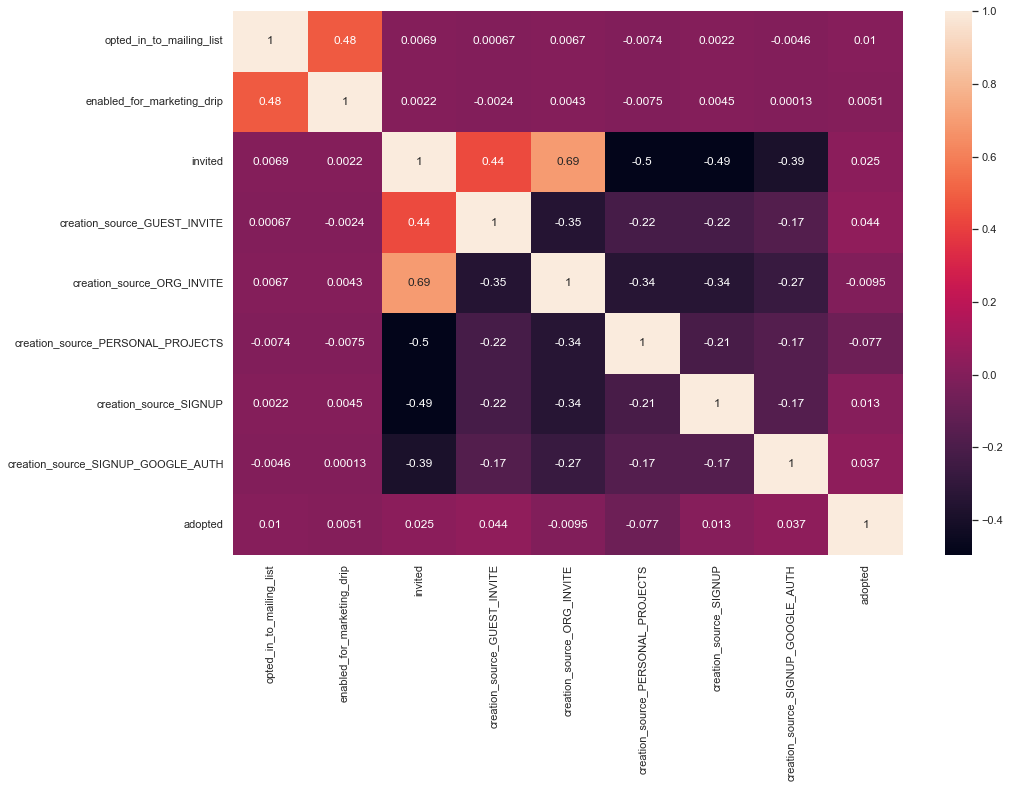

In [286]:
# plot the heatmap 
plt.figure(figsize=(15,10))
sns.heatmap(user_info.corr(),annot=True)

In [287]:
# sort the corrolation values
user_info.corr()['adopted'].sort_values()

creation_source_PERSONAL_PROJECTS    -0.076690
creation_source_ORG_INVITE           -0.009465
enabled_for_marketing_drip            0.005118
opted_in_to_mailing_list              0.010412
creation_source_SIGNUP                0.012730
invited                               0.024877
creation_source_SIGNUP_GOOGLE_AUTH    0.037450
creation_source_GUEST_INVITE          0.044059
adopted                               1.000000
Name: adopted, dtype: float64

Summary:
* Higher negative correlation between creation_source_PERSONAL_PROJECTS and adopttion.
* Higher positive correlations between below features and adoption
    * invited
    * creation_source_GUEST_INVITE
    * creation_source_SIGNUP_GOOGLE_AUTH

## 3- Classification Modeling

Our problem is a classification problem with binary output. We will use logistic regression to model our data.

In [305]:
y = user_info[['adopted']].values
X = user_info.drop(['adopted'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [333]:
model = LogisticRegression()

model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n',classification_report(y_test, y_pred))

Confusion matrix:
 [[2102    0]
 [ 298    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      2102
           1       0.00      0.00      0.00       298

    accuracy                           0.88      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.77      0.88      0.82      2400



/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakisaabbasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [334]:
feature_importance=pd.DataFrame(np.hstack((np.array([X.columns]).T, model.coef_.T)), columns=['feature', 'importance'])
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False)


,feature,importance
7,creation_source_SIGNUP_GOOGLE_AUTH,0.316240
3,creation_source_GUEST_INVITE,0.202640
6,creation_source_SIGNUP,0.123994
2,invited,0.108605
0,opted_in_to_mailing_list,0.019557
1,enabled_for_marketing_drip,-0.015772
4,creation_source_ORG_INVITE,-0.094035
5,creation_source_PERSONAL_PROJECTS,-0.549094


### 3- Colclusion and recommendations:

* The data is not balanced at all, therefore the better approach would be to balanced our data first and then build our mode.
* Both the correlations from heatmap and the feature importnace in our logistic model suggests very similar features. It seems how the users created their account can be an important feature to affect the users to be adopted or not. as seen below, users with GOOGLE_AUTH and GUEST_INVITE, have a higher probability to be addopted
    * creation_source_SIGNUP_GOOGLE_AUTH
    * creation_source_GUEST_INVITE
    * creation_source_SIGNUP
And users sighned up with PERSONAL_PROJECTS have the lower probability.
Therefore we recommend, to mention make the GOOGLE_AUTH on the top and more visible to users while signing up. Also send some promotions to users who invite othere to join.